# Explore the SSO reflectance spectra in Gaia DR3

This builds on the work of Joost Barendse (MSc research project). This notebook is for exploring the reflectance spectra.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

from astropy.table import Table

from agabpylib.plotting.plotstyles import useagab, apply_tufte
from reflspectratools import (
    name_to_mpcnum,
    overplot_spectrum,
    plot_spectra_collection,
    load_dr3_data,
    create_ml_training_classes,
)

useagab(fontsize=22, linewidths=3, axislinewidths=2)

## Read in the data and make some exploratory plots

The SSO reflectance spectra were retrieved with the simple query:
```sql
select * from gaiadr3.sso_reflectance_spectrum
```

The reflectance spectra are corrected according to the prescriptions by [Tinaut-Ruano et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...669L..14T/abstract). The factors by which to multiply the `reflectance_spectrum` column are listed in their table 1.

| Wavelength (nm) | Correction Factor |
| -- | -- |
| 374.0 | 1.07 |
| 418.0 | 1.05 |
| 462.0 | 1.02 |
| 506.0 | 1.01 |

The code below reads in the data, where optionally the first and last three wavelength bins of the spectra are removed (these are less reliable).

In [2]:
ssodata = load_dr3_data(clipspectra=False)
wavelengths = ssodata["wavelength"].unique()
wavelengths.sort()

## Simple data checks

In [3]:
n_sso = len(ssodata.number_mp.unique())
print(
    "amount of NaN's in the reflectance spectra:",
    len(np.where(np.isnan(ssodata.reflectance_spectrum_normalized))[0]),
)
print(
    np.count_nonzero(ssodata.reflectance_spectrum_flag == 0), " data points have flag 0"
)
print(
    np.count_nonzero(ssodata.reflectance_spectrum_flag == 1), " data points have flag 1"
)
print(
    np.count_nonzero(ssodata.reflectance_spectrum_flag == 2), " data points have flag 2"
)

amount of NaN's in the reflectance spectra: 27244
881716  data points have flag 0
13341  data points have flag 1
73231  data points have flag 2


## Plot all SSO spectra

The code below is adapted from [this example](https://matplotlib.org/stable/gallery/statistics/time_series_histogram.html#sphx-glr-gallery-statistics-time-series-histogram-py) from Matplotlib.

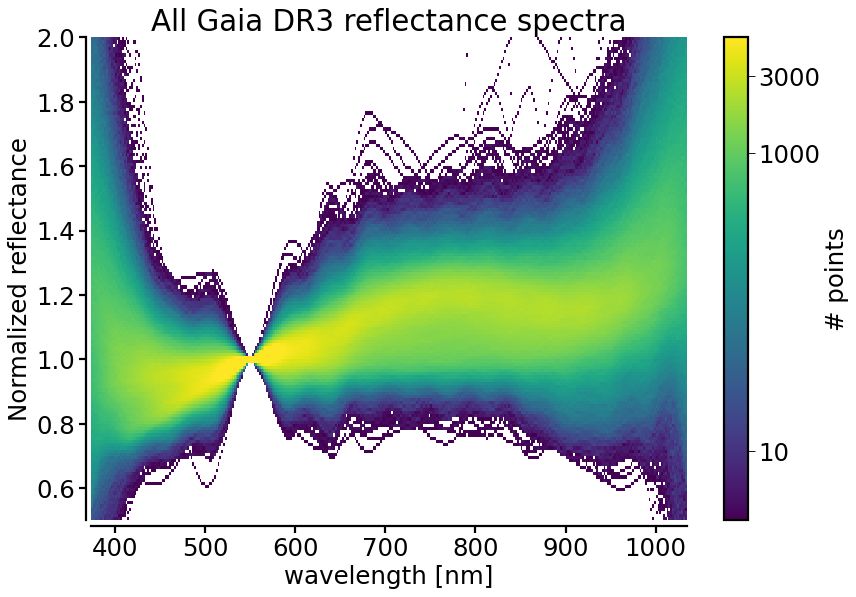

In [4]:
fig, axb = plt.subplots(1, 1, figsize=(12, 8))
apply_tufte(axb)

plot_spectra_collection(
    ssodata, axb, fig, None, plotall=True, cbarticks=[10, 1000, 3000]
)
axb.set_title("All Gaia DR3 reflectance spectra")

plt.show()

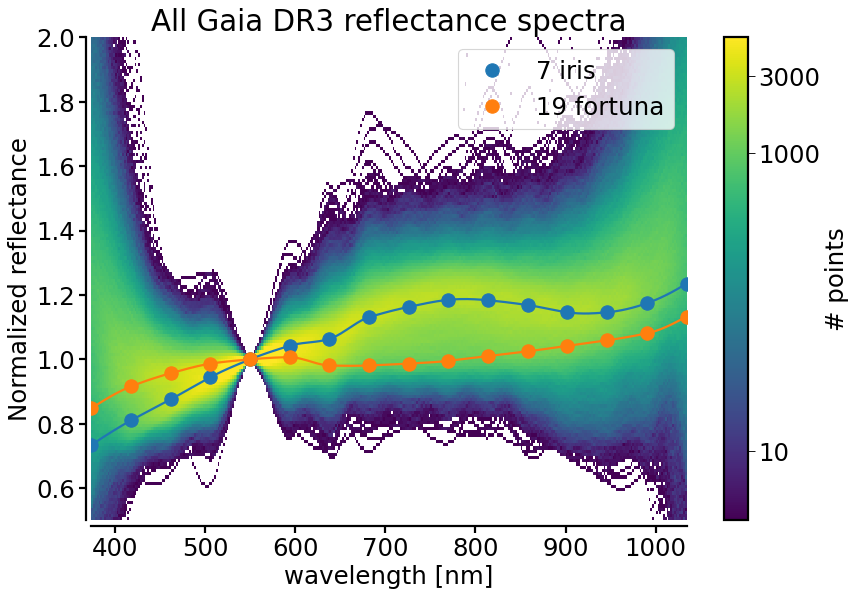

In [6]:
sso_names = ["iris", "fortuna"]
mpcnums = name_to_mpcnum(ssodata, sso_names)

fig, axc = plt.subplots(1, 1, figsize=(12, 8))
apply_tufte(axc)

plot_spectra_collection(
    ssodata, axc, fig, None, plotall=True, cbarticks=[10, 1000, 3000]
)
axc.set_title("All Gaia DR3 reflectance spectra")

overplot_spectrum(ssodata, axc, mpcnums, interpolate=True, addlegend=True, ms=12, lw=2)

plt.show()

## Examine the known Ch/Cgh type asteroids

The data are stored in `Ch-Cgh-asteroids-literature.txt`.

Notes:
* Two of the literature asteroids are not in the Gaia DR3 data:
    * 1694 Kaiser
    * 6283 1980VX1
* There is one outlier among the Gaia DR3 reflectance spectra for these asteroids
    * 3104 Durer. The classification is Sa according to [Hasegawa et al (2021)](https://ui.adsabs.harvard.edu/abs/2021PASJ...73..240H/abstract)

In [6]:
chtable = pd.read_table(
    "./data/Ch-Cgh-asteroids-literature.txt",
    delimiter="\s+",
    names=[
        "Number",
        "Designation",
        "H",
        "G",
        "prop.a",
        "prop.e",
        "prop.sini",
        "D",
        "D_unc",
        "pV",
        "pV_Unc",
        "Period",
        "SpectroscopicClasses",
        "Family",
        "a*",
        "i_z",
        "Ref",
    ],
    skiprows=1,
)

In [7]:
notindr3 = [
    chnum for chnum in chtable.Number if ssodata.loc[ssodata.number_mp == chnum].empty
]
print(f"Ch/Cgh literature asteroids not in DR3 {notindr3}")

outlier = [
    chnum
    for chnum in chtable.Number
    if np.any(
        ssodata.loc[
            (ssodata.number_mp == chnum) & (ssodata.wavelength == 814)
        ].reflectance_spectrum
        > 1.2
    )
]
print(f"Outlier asteroid in plot below {outlier}")

Ch/Cgh literature asteroids not in DR3 [1694, 6283]
Outlier asteroid in plot below [3104]


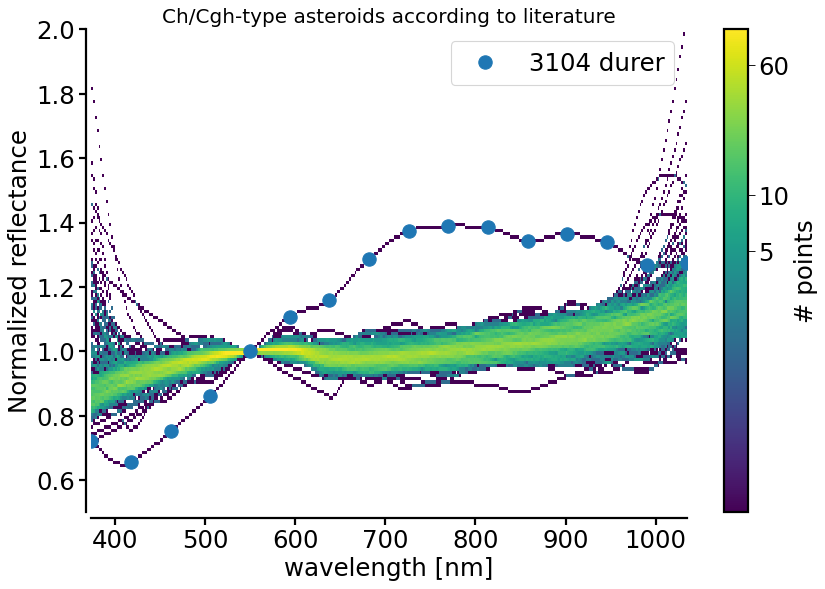

In [8]:
fig, axd = plt.subplots(1, 1, figsize=(12, 8))
apply_tufte(axd)
plot_spectra_collection(
    ssodata, axd, fig, chtable.Number.to_list(), cbarticks=[5, 10, 60]
)

overplot_spectrum(ssodata, axd, outlier, interpolate=False, addlegend=True, ms=12, lw=2)
axd.set_title("Ch/Cgh-type asteroids according to literature", fontsize=18)

plt.show()

## Examine the asteroids classified by Joost Barendse, with checks by Marco Delbo

These data are in the files `Asteroid_Classification_vAB.xlsx` and `Asteroid_Classification_vAB-finalclasses.csv`. The first file contains all the classification work and comments. The second file only contains the final assessments. It lists the following:
* MPC number
* Asteroid type/class
* Whether or not an h-band is present 
    * yes, no, dubious, other types of bands, and empty (i.e. unknown)

Eventually for the machine learning the following groups are of interest:
* Non-C-type asteroids
* C-type asteroids without h-band
* C-type asteroids with h-band (Ch, Cgh)

Spectra with one or more instances of `reflectance_spectrum_flag==2` are filtered out.

The groups are plotted below in order to see what the Gaia DR3 spectra look like..

In [9]:
ssotypes = create_ml_training_classes(ssodata, filter=True)

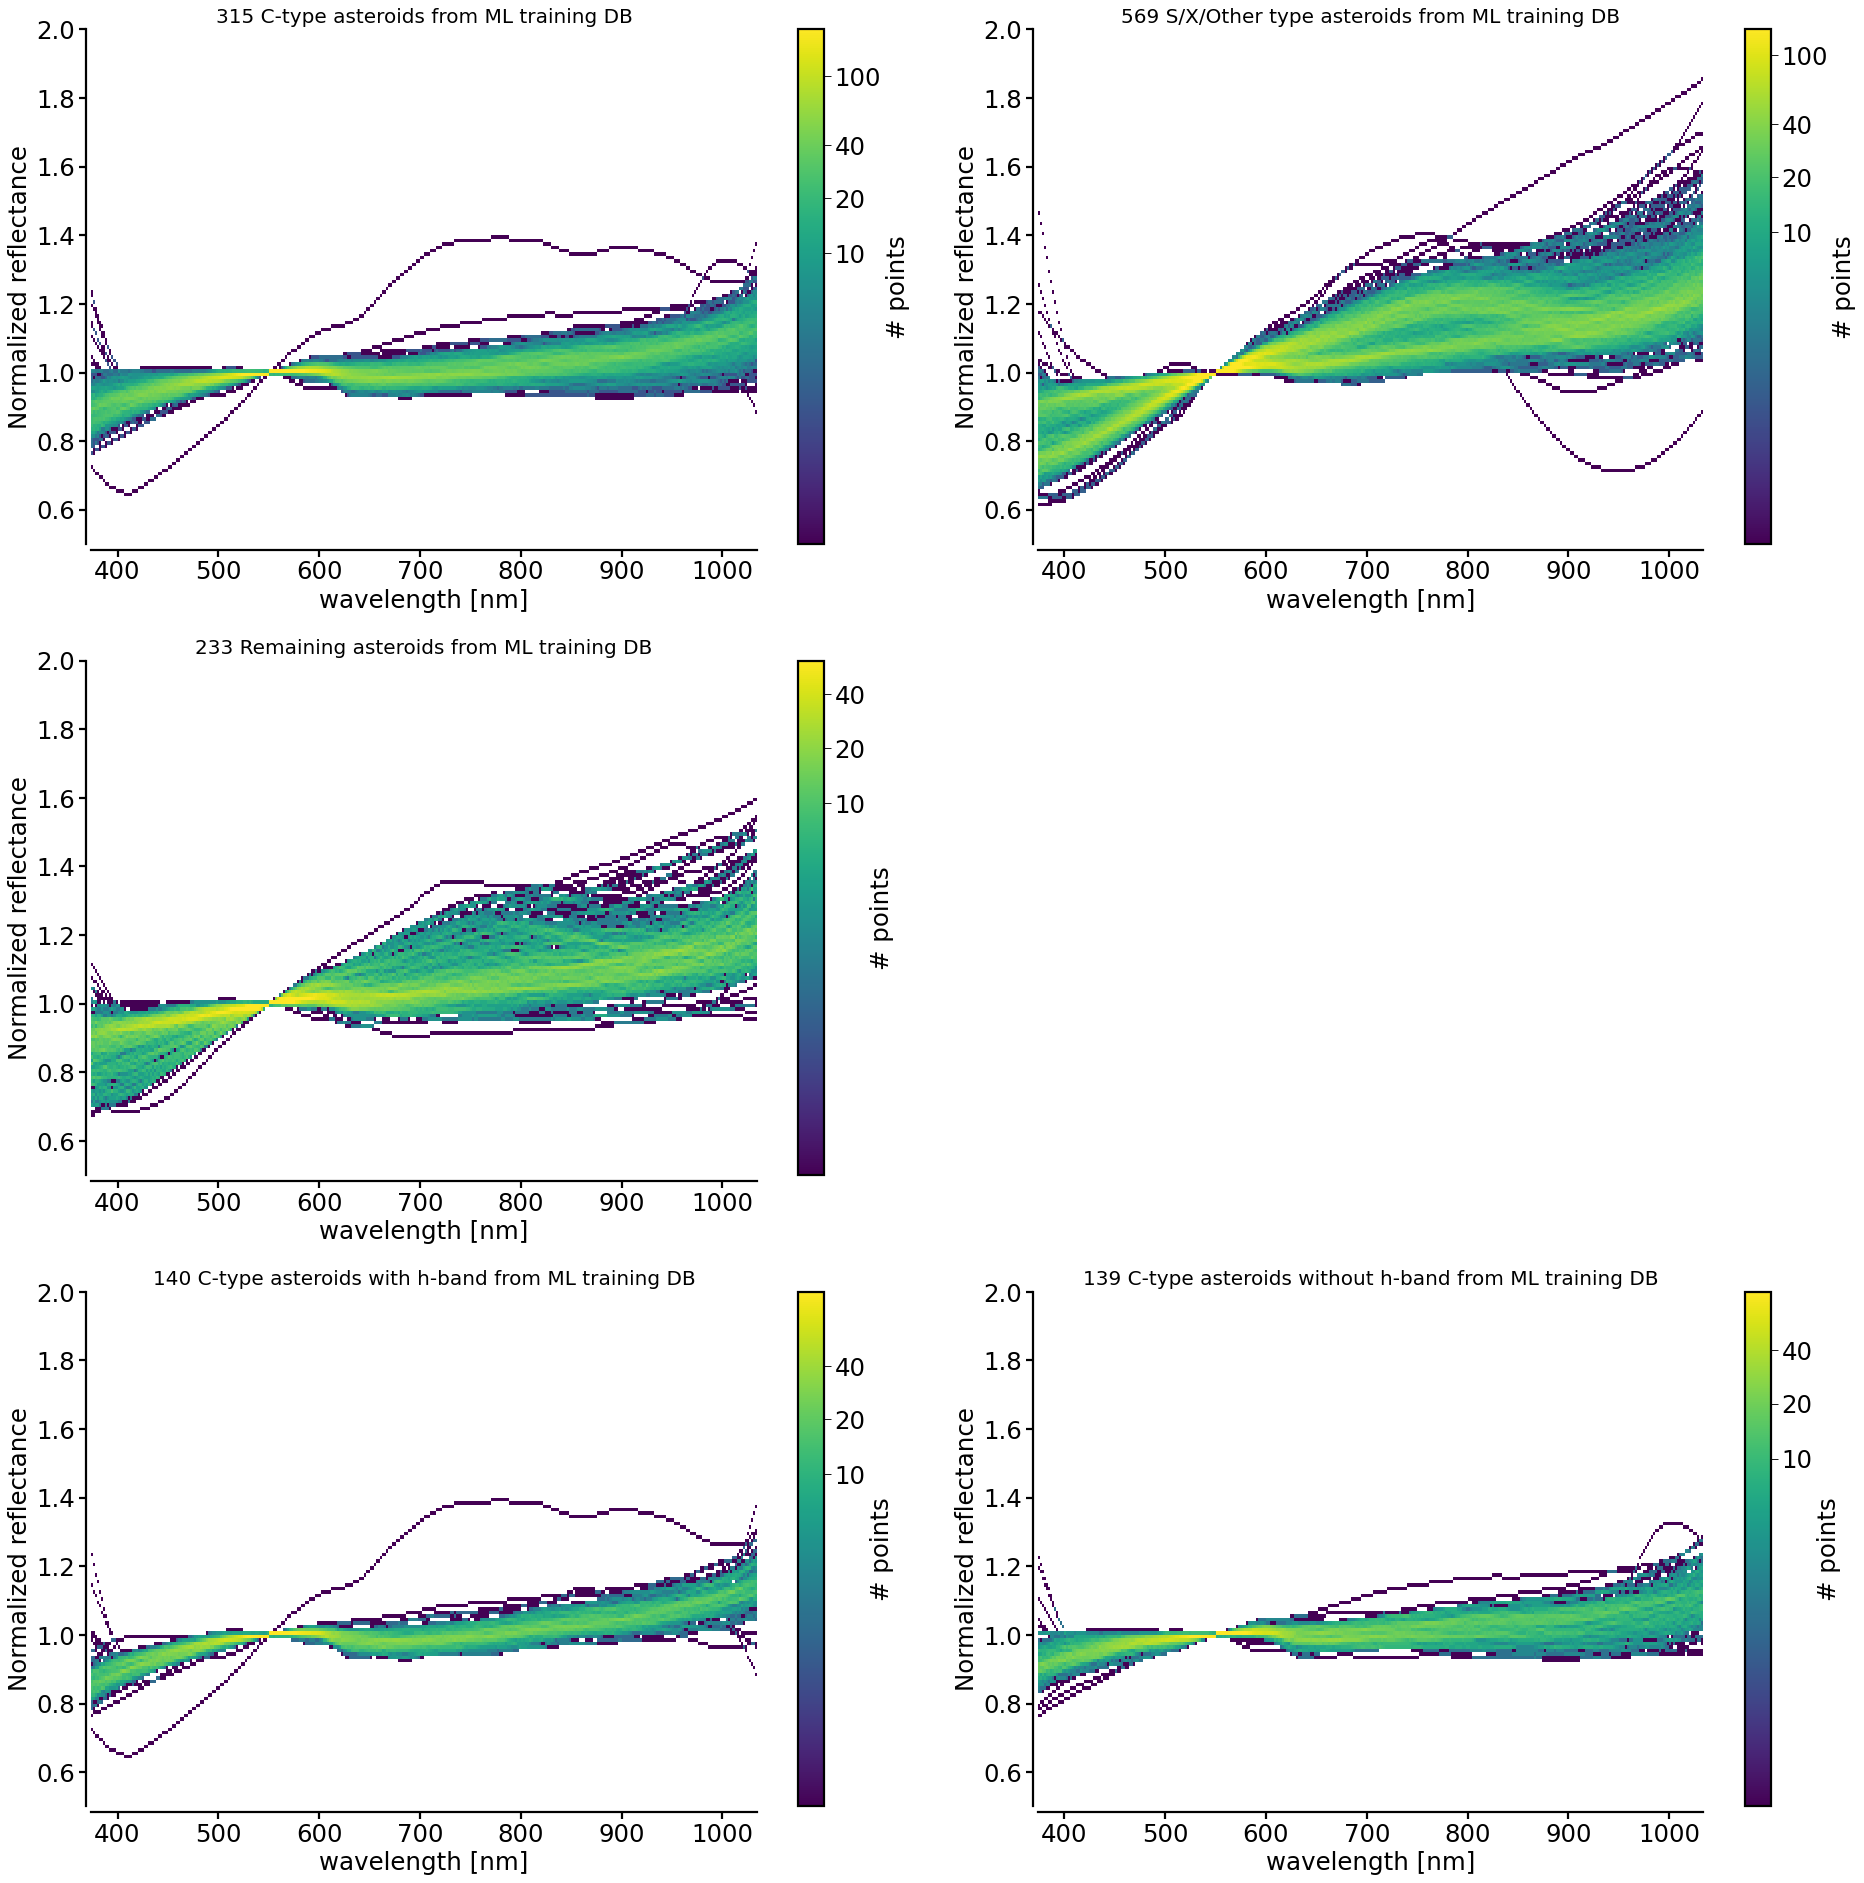

In [11]:
fig = plt.figure(figsize=(2 * 12, 3 * 8), tight_layout=True)
gs = GridSpec(3, 2, figure=fig)
axmltr = []
axmltr.append(fig.add_subplot(gs[0, 0]))
axmltr.append(fig.add_subplot(gs[0, 1]))
axmltr.append(fig.add_subplot(gs[1, 0]))
axmltr.append(fig.add_subplot(gs[2, 0]))
axmltr.append(fig.add_subplot(gs[2, 1]))
for ax in axmltr:
    apply_tufte(ax)

plot_spectra_collection(
    ssodata, axmltr[0], fig, ssotypes["C"], cbarticks=[10, 20, 40, 100]
)
axmltr[0].set_title(
    f"{len(ssotypes['C'])} C-type asteroids from ML training DB", fontsize=18
)

plot_spectra_collection(
    ssodata, axmltr[1], fig, ssotypes["other"], cbarticks=[10, 20, 40, 100]
)
axmltr[1].set_title(
    f"{len(ssotypes['other'])} S/X/Other type asteroids from ML training DB",
    fontsize=18,
)

plot_spectra_collection(
    ssodata, axmltr[2], fig, ssotypes["rest"], cbarticks=[10, 20, 40]
)
axmltr[2].set_title(
    f"{len(ssotypes['rest'])} Remaining asteroids from ML training DB", fontsize=18
)

plot_spectra_collection(
    ssodata, axmltr[3], fig, ssotypes["C_h"], cbarticks=[10, 20, 40]
)
axmltr[3].set_title(
    f"{len(ssotypes['C_h'])} C-type asteroids with h-band from ML training DB",
    fontsize=18,
)

plot_spectra_collection(
    ssodata, axmltr[4], fig, ssotypes["C_no_h"], cbarticks=[10, 20, 40]
)
axmltr[4].set_title(
    f"{len(ssotypes['C_no_h'])} C-type asteroids without h-band from ML training DB",
    fontsize=18,
)

plt.show()